In [ ]:
!pip install laspy

   ---------------------------------------- 0.0/84.3 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/84.3 kB ? eta -:--:--
   ---------------------------------------- 84.3/84.3 kB 1.6 MB/s eta 0:00:00


In [1]:
# Imports
# import os
# import re
# import csv
# import typing
# import itertools
# import json
# import logging
# import warnings
# import evaluate
# import types
import pandas as pd
import sklearn as sk
import numpy as np
# import torch
# import math
import shapely

import matplotlib.pyplot as plt
import laspy # Reading LAS file format
from lib import download_maps
from tqdm import tqdm # Loading bars
import geopandas as gpd

In [2]:
def gather_data():
    download_maps.main()

In [3]:
# Load area points from the text file and create a polygon
def load_area_polygon(file_path):
    """
    Reads a text file containing coordinates and creates a Shapely polygon.

    Parameters:
        file_path (str): Path to the file containing area coordinates.

    Returns:
        shapely.Polygon: Polygon constructed from the coordinates.
    """
    coordinates = []
    with open(file_path, 'r') as f:
        for line in f:
            if len(line.split()) == 3:  # Check for valid coordinate lines
                _, x, y = line.strip().split()
                coordinates.append((float(y), float(x)))  # Swap X and Y for proper polygon alignment
    return shapely.Polygon(coordinates)  # Return the constructed polygon

In [4]:
# Modify LAS points' classification inside the polygon
def classify_points_in_area(las, polygon, new_classification, output_path):
    """
    Updates the classification of LAS file points within a given polygon.

    Parameters:
        las (str): Input LAS file.
        polygon (shapely.Polygon): Polygon to classify points inside.
        new_classification (int): New classification value for points within the polygon.
        output_path (str): Path to save the modified LAS file.

    Returns:
        None
    """

    # Extract LAS point X, Y coordinates
    points = np.column_stack((las.x, las.y))

    # Convert points to a Shapely GeometryArray (vectorized)
    points_geom = shapely.points(points)

    # Pre-filter points using the polygon's bounding box
    bbox_mask = shapely.contains(shapely.box(*polygon.bounds), points_geom)

    # Apply fine-grained point-in-polygon test to remaining points
    final_mask = shapely.contains(polygon, points_geom[bbox_mask])

    # Combine masks
    mask = np.zeros(len(points), dtype=bool)
    mask[bbox_mask] = final_mask

    # Apply the new classification to points within the polygon
    las.classification[mask] = new_classification

    # Write modified points to a new LAS file
    las.write(output_path)

In [5]:
# Rasterize a shapely polygon for overlay
def rasterize_polygon(polygon, x_min, x_max, y_min, y_max, resolution):
    """
    Converts a polygon into a binary mask over a 2D grid.

    Parameters:
        polygon (shapely.Polygon): Polygon to rasterize.
        x_min, x_max, y_min, y_max (float): Bounding box of the grid.
        resolution (int): Resolution of the grid (number of rows/columns).

    Returns:
        np.ndarray: 2D binary mask (1 inside the polygon, 0 outside).
    """
    # Initialize an empty grid
    grid = np.zeros((resolution, resolution), dtype=np.uint8)
    
    # Create evenly spaced coordinates within the bounding box
    x_range = np.linspace(x_min, x_max, resolution)
    y_range = np.linspace(y_min, y_max, resolution)
    
    # Iterate through each grid cell and check if it is within the polygon
    for i, y in enumerate(y_range):
        for j, x in enumerate(x_range):
            if polygon.contains(shapely.Point(x, y)):  # Check if the grid point is inside the polygon
                grid[i, j] = 1  # Mark the grid cell as inside the polygon
    return grid

In [6]:
# Function to blend mask into an image with transparency
def apply_transparency(image, mask, mask_color, alpha):
    """
    Applies a semi-transparent mask overlay to an image.

    Parameters:
        image (np.ndarray): Original RGB image (H x W x 3).
        mask (np.ndarray): Binary mask (H x W) where 1 indicates the mask region.
        mask_color (list): RGB color for the mask (e.g., [255, 0, 0] for red).
        alpha (float): Transparency level (0 to 1, where 1 is fully opaque).

    Returns:
        np.ndarray: RGB image with the mask applied.
    """
    # Create a copy of the original image to avoid overwriting
    blended_image = image.copy()
    
    # Get indices where the mask is active
    mask_indices = mask == 1  # Binary mask where 1 indicates the mask area
    
    # Blend mask color with the original image in the masked region
    for channel in range(3):  # Loop over RGB channels
        blended_image[..., channel][mask_indices] = (
            (1 - alpha) * blended_image[..., channel][mask_indices] + alpha * mask_color[channel]
        )
    
    return blended_image

In [7]:
def generate_color_image(laz_files, resolution=512, additional_features=[]):
    """
    Generates a color image from multiple LAZ files.

    Parameters:
        laz_files (list): List of LAZ objects containing point cloud data.
        resolution (int): Resolution for the output grid.
        additional_features (list): List of additional features to include (e.g., 'z', 'classification').

    Returns:
        tuple: (color_image, additional_feature_maps)
            - color_image: 3D numpy array (H x W x 3) for RGB.
            - additional_feature_maps: Dictionary of feature maps for additional features.
    """
    # Initialize color image
    color_image = np.zeros((resolution, resolution, 3), dtype=np.uint8)

    # Additional feature maps
    feature_maps = {feature: np.zeros((resolution, resolution)) for feature in additional_features}

    for las in laz_files:
        # Extract X, Y, RGB
        x, y = las.x, las.y
        red, green, blue = las.red, las.green, las.blue

        # Extract additional features
        features = {feature: getattr(las, feature) for feature in additional_features}

        # Normalize X, Y to fit into a 2D grid
        x_min, x_max = np.min(las.header.x_min), np.max(las.header.x_max)
        y_min, y_max = np.min(las.header.y_min), np.max(las.header.y_max)

        x_norm = ((x - x_min) / (x_max - x_min)) * (resolution - 1)
        y_norm = ((y - y_min) / (y_max - y_min)) * (resolution - 1)

        # Convert to integers for indexing
        x_indices = np.clip(x_norm.astype(np.int32), 0, resolution - 1)
        y_indices = np.clip(y_norm.astype(np.int32), 0, resolution - 1)

        # Flatten indices
        flat_indices = y_indices * resolution + x_indices
        unique_indices, inverse_indices = np.unique(flat_indices, return_inverse=True)

        # Aggregate RGB values
        red_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)
        green_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)
        blue_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)

        np.add.at(red_aggregated, inverse_indices, red / 65535 * 255)
        np.add.at(green_aggregated, inverse_indices, green / 65535 * 255)
        np.add.at(blue_aggregated, inverse_indices, blue / 65535 * 255)

        # Assign to color image
        color_image.flat[unique_indices * 3] = (red_aggregated / np.bincount(inverse_indices)).astype(np.uint8)
        color_image.flat[unique_indices * 3 + 1] = (green_aggregated / np.bincount(inverse_indices)).astype(np.uint8)
        color_image.flat[unique_indices * 3 + 2] = (blue_aggregated / np.bincount(inverse_indices)).astype(np.uint8)

        # Aggregate and assign additional features
        for feature, feature_map in feature_maps.items():
            feature_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)
            np.add.at(feature_aggregated, inverse_indices, features[feature])
            feature_map.flat[unique_indices] = feature_aggregated / np.bincount(inverse_indices)

    return color_image, feature_maps

In [8]:
def plot_color_images(color_image, masked_color_image, title1='Original Colorized Image', title2='Masked Colorized Image'):
    """
    Plots the color image and masked color image side by side.

    Parameters:
        color_image (numpy.ndarray): Original color image (H x W x 3).
        masked_color_image (numpy.ndarray): Masked color image (H x W x 3).
        title1 (str): Title for the first subplot.
        title2 (str): Title for the second subplot.
    """
    fig, axs = plt.subplots(1, 2, figsize=(24, 18))

    # Original Colorized Image
    axs[0].imshow(np.flip(color_image, axis=0))
    axs[0].set_title(title1)
    axs[0].axis('off')

    # Masked Colorized Image
    axs[1].imshow(np.flip(masked_color_image, axis=0))
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.show()

In [92]:
las = laspy.read('../data/lazFiles/506490_2020_tava.laz') # Tuleb ära muuta
# las = laspy.read('./test.laz')
# hillfort_area = load_area_polygon('../data/temp/241.txt') # Lihula mõisa pargi hulknurga koordinaadid (saab kätte Geoportaalist)

In [93]:
display(las.xyz)
display(las.xyz.shape)

array([[4.90009840e+05, 6.50600801e+06, 1.15900000e+01],
       [4.90009610e+05, 6.50600894e+06, 1.16000000e+01],
       [4.90009380e+05, 6.50600985e+06, 1.15500000e+01],
       ...,
       [4.90999420e+05, 6.50699159e+06, 8.66000000e+00],
       [4.90999620e+05, 6.50699243e+06, 8.61000000e+00],
       [4.90999810e+05, 6.50699328e+06, 8.61000000e+00]])

(3004416, 3)

In [96]:
print(np.min(las.x), np.max(las.x))
print(np.min(las.y), np.max(las.y))
print(np.min(las.z), np.max(las.z))

490000.0 490999.99
6506000.0 6506999.99
-40.730000000000004 77.16


In [95]:
print(las.header.x_min, las.header.x_max, las.header.x_scale)
print(las.header.y_min, las.header.y_max, las.header.y_scale)
print(las.header.z_min, las.header.z_max, las.header.z_scale)

490000.0 490999.99 0.01
6506000.0 6506999.99 0.01
-40.730000000000004 77.16 0.01


In [77]:
las.x

<ScaledArrayView([0.1 0.1 0.1 ... 1.  1.  1. ])>

In [78]:
las.y

<ScaledArrayView([0.   0.   0.   ... 0.81 0.81 0.81])>

In [79]:
las.z

<ScaledArrayView([0.25 0.21 0.13 ... 0.19 0.23 0.25])>

In [80]:
las.point_format.id

8

In [81]:
list(las.point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'synthetic',
 'key_point',
 'withheld',
 'overlap',
 'scanner_channel',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'user_data',
 'scan_angle',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue',
 'nir',
 'Amplitude',
 'Pulse width',
 'Reflectance',
 'Deviation']

In [82]:
list(las.point_format.extra_dimension_names)

['Amplitude', 'Pulse width', 'Reflectance', 'Deviation']

laspy name | size (bits) | type
| ------ | -------- | -------- |
u1 or uint8 | 8 | unsigned
i1 or int8 | 8 | signed
u2 or uint16 | 16 | unsigned
i2 or int16 | 16 | signed
u4 or uint32 | 32 | unsigned
i4 or int32 | 32 | signed
u8 or uint64 | 64 | unsigned
i8 or int64 | 64 | signed
f4 or float32 | 32 | floating
f8 or float64 | 64 | floating

In [83]:
las.points.array

array([( 10,  0, 25, 44869, 17, 80, 5, 150,  463, 23367, 3.67655690e+08, 25344, 33280, 18688, 54784, 1024, 0,  -446, 36),
       ( 10,  0, 21, 41287, 34,  0, 5, 107,  479, 23367, 3.67655691e+08, 17152, 19712, 16384, 36096,  943, 0,  -610,  8),
       ( 10,  0, 13, 44105, 51,  0, 1,   2,  479, 23367, 3.67655691e+08, 24576, 26624, 20224, 39936, 1066, 0,  -481, 12),
       ...,
       (100, 81, 19, 39058, 50,  0, 5,  78, 3568, 23367, 3.67655682e+08, 32256, 32512, 22784, 47616,  765, 0,  -712, 11),
       (100, 81, 23, 31019, 66,  0, 5, 123, 3583, 23367, 3.67655682e+08,  9728, 12288, 11776, 26112,  398, 0, -1080,  0),
       (100, 81, 25, 42248, 33,  8, 5, 152, 4624, 23366, 3.67655413e+08, 15104, 13056, 11520, 24576,  857, 0,  -566,  5)],
      dtype=[('X', '<i4'), ('Y', '<i4'), ('Z', '<i4'), ('intensity', '<u2'), ('bit_fields', 'u1'), ('classification_flags', 'u1'), ('classification', 'u1'), ('user_data', 'u1'), ('scan_angle', '<i2'), ('point_source_id', '<u2'), ('gps_time', '<f8'), ('red

In [84]:
np.unique(las.points.classification, return_counts=True) # unique, counts

(array([ 1,  2,  5,  6,  9, 12, 18], dtype=uint8),
 array([ 35219,  73003, 114283,    284,     69,   8086,     11],
       dtype=int64))

In [85]:
dir(las.point_format)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_extra_dimension',
 'dimension_by_name',
 'dimension_names',
 'dimensions',
 'dtype',
 'extra_dimension_names',
 'extra_dimensions',
 'has_waveform_packet',
 'id',
 'num_extra_bytes',
 'num_standard_bytes',
 'remove_extra_dimension',
 'size',
 'standard_dimension_names',
 'standard_dimensions']

In [86]:
las.point_format.id

8

In [87]:
dir(las)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_points',
 '_write_to',
 'add_extra_dim',
 'add_extra_dims',
 'change_scaling',
 'evlrs',
 'header',
 'point_format',
 'points',
 'remove_extra_dim',
 'remove_extra_dims',
 'update_header',
 'vlrs',
 'write',
 'xyz']

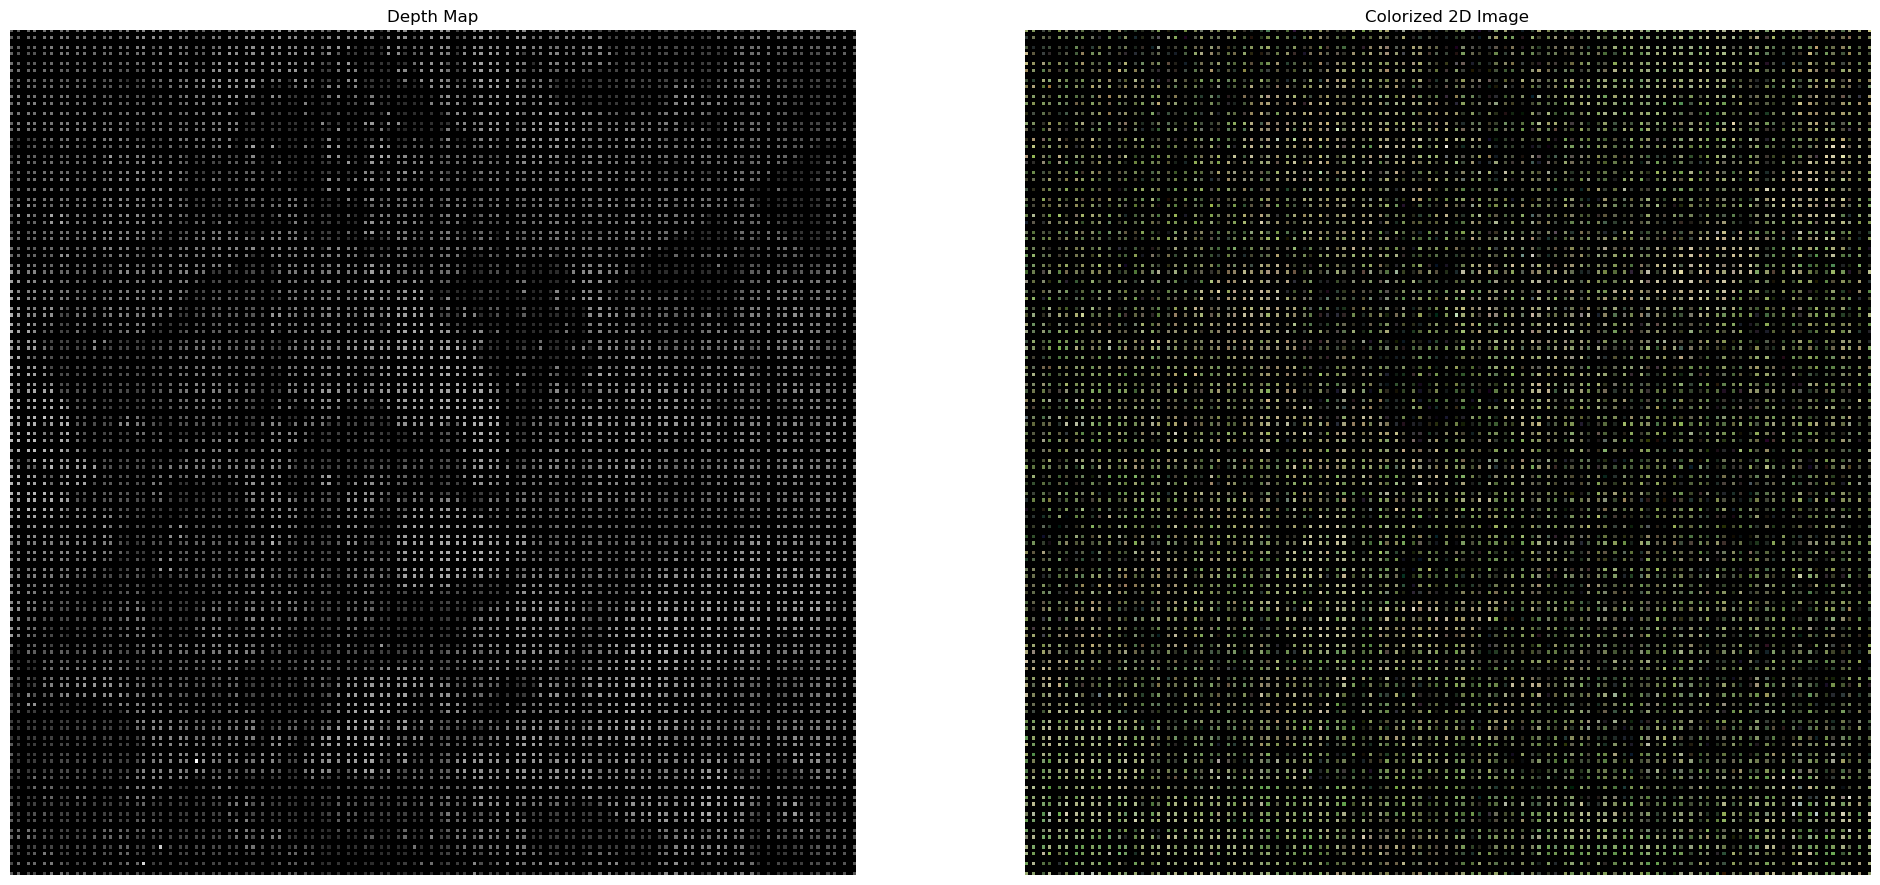

In [90]:
# Extract X, Y, Z coordinates and color information (red, green, blue)
x = las.x
y = las.y
z = las.z
red = las.red
green = las.green
blue = las.blue

# Normalize X, Y to fit into a 2D grid (for the depth map and color image)
resolution = 256  # Output resolution for the images (nxn pixels)
x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)

# Normalize x and y to fit the 2D image grid
x_norm = ((x - x_min) / (x_max - x_min)) * (resolution - 1)
y_norm = ((y - y_min) / (y_max - y_min)) * (resolution - 1)

# Create empty arrays for depth map and color image
depth_map = np.zeros((resolution, resolution))
color_image = np.zeros((resolution, resolution, 3), dtype=np.uint8)  # 3 channels for RGB

# Populate the depth map and color image
for i in range(len(x_norm)):
    xi = int(x_norm[i])
    yi = int(y_norm[i])
    
    # Depth map: take maximum Z value for each pixel
    depth_map[yi, xi] = max(depth_map[yi, xi], z[i])
    
    # Color image: set red, green, blue values (normalize to 0-255)
    color_image[yi, xi, 0] = red[i] / 65535 * 255  # Normalize 16-bit to 8-bit
    color_image[yi, xi, 1] = green[i] / 65535 * 255
    color_image[yi, xi, 2] = blue[i] / 65535 * 255

# Normalize the depth map to the range [0, 255]
depth_map_normalized = 255 * (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))
depth_map_normalized = depth_map_normalized.astype(np.uint8)

# Plot both depth map and colorized image side by side
fig, axs = plt.subplots(1, 2, figsize=(24, 18))

# Depth map (left)
axs[0].imshow(depth_map_normalized, cmap='gray')
axs[0].set_title('Depth Map')
axs[0].axis('off')

# Colorized image (right)
axs[1].imshow(color_image)
axs[1].set_title('Colorized 2D Image')
axs[1].axis('off')
plt.show()

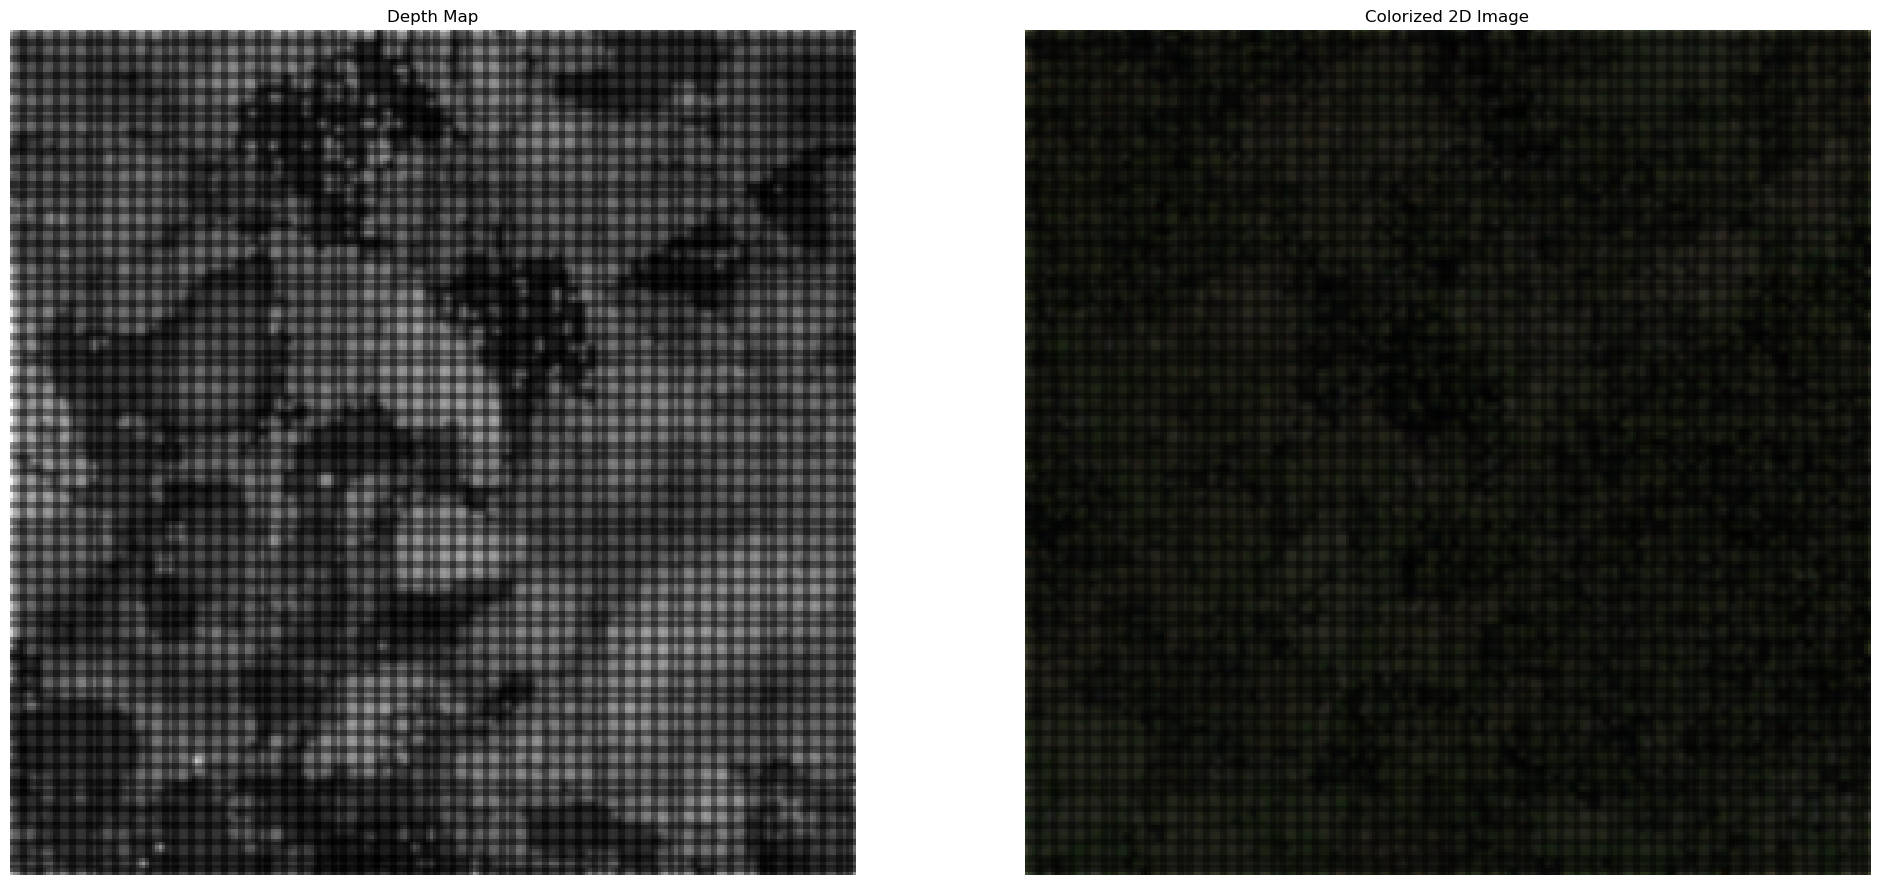

In [91]:
from scipy.ndimage import gaussian_filter, binary_fill_holes

# Smooth using Gaussian filtering
smoothed_depth_map = gaussian_filter(depth_map_normalized, sigma=1)

# For the color image: interpolate missing pixel values
for i in range(3):
    color_image[:, :, i] = gaussian_filter(color_image[:, :, i], sigma=1)
    
# Plot both depth map and colorized image side by side
fig, axs = plt.subplots(1, 2, figsize=(24, 18))

# Depth map (left)
axs[0].imshow(smoothed_depth_map, cmap='gray')
axs[0].set_title('Depth Map')
axs[0].axis('off')

# Colorized image (right)
axs[1].imshow(color_image)
axs[1].set_title('Colorized 2D Image')
axs[1].axis('off')
plt.show()

(490517.75, 6505860.8, 490894.93, 6506200.29)

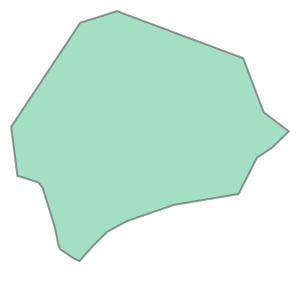

In [ ]:
hillfort_area = load_area_polygon('241_V2.txt')
display(hillfort_area.bounds)
display(hillfort_area)

In [70]:
dir(las.header)

['DEFAULT_POINT_FORMAT',
 'DEFAULT_VERSION',
 '_OLD_LASPY_NAMES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_point_format',
 '_prefetch_header_data',
 '_sync_extra_bytes_vlr',
 '_version',
 '_vlrs',
 'add_crs',
 'add_extra_dim',
 'add_extra_dims',
 'are_points_compressed',
 'creation_date',
 'evlrs',
 'extra_header_bytes',
 'extra_vlr_bytes',
 'file_source_id',
 'generating_software',
 'global_encoding',
 'grow',
 'major_version',
 'max_point_count',
 'maxs',
 'minor_version',
 'mins',
 'number_of_evlrs',
 'number_of_points_by_return',
 'offset_to_point_data',
 'offsets',
 'parse_crs',
 'partial_reset',
 'point_count',
 'point_fo

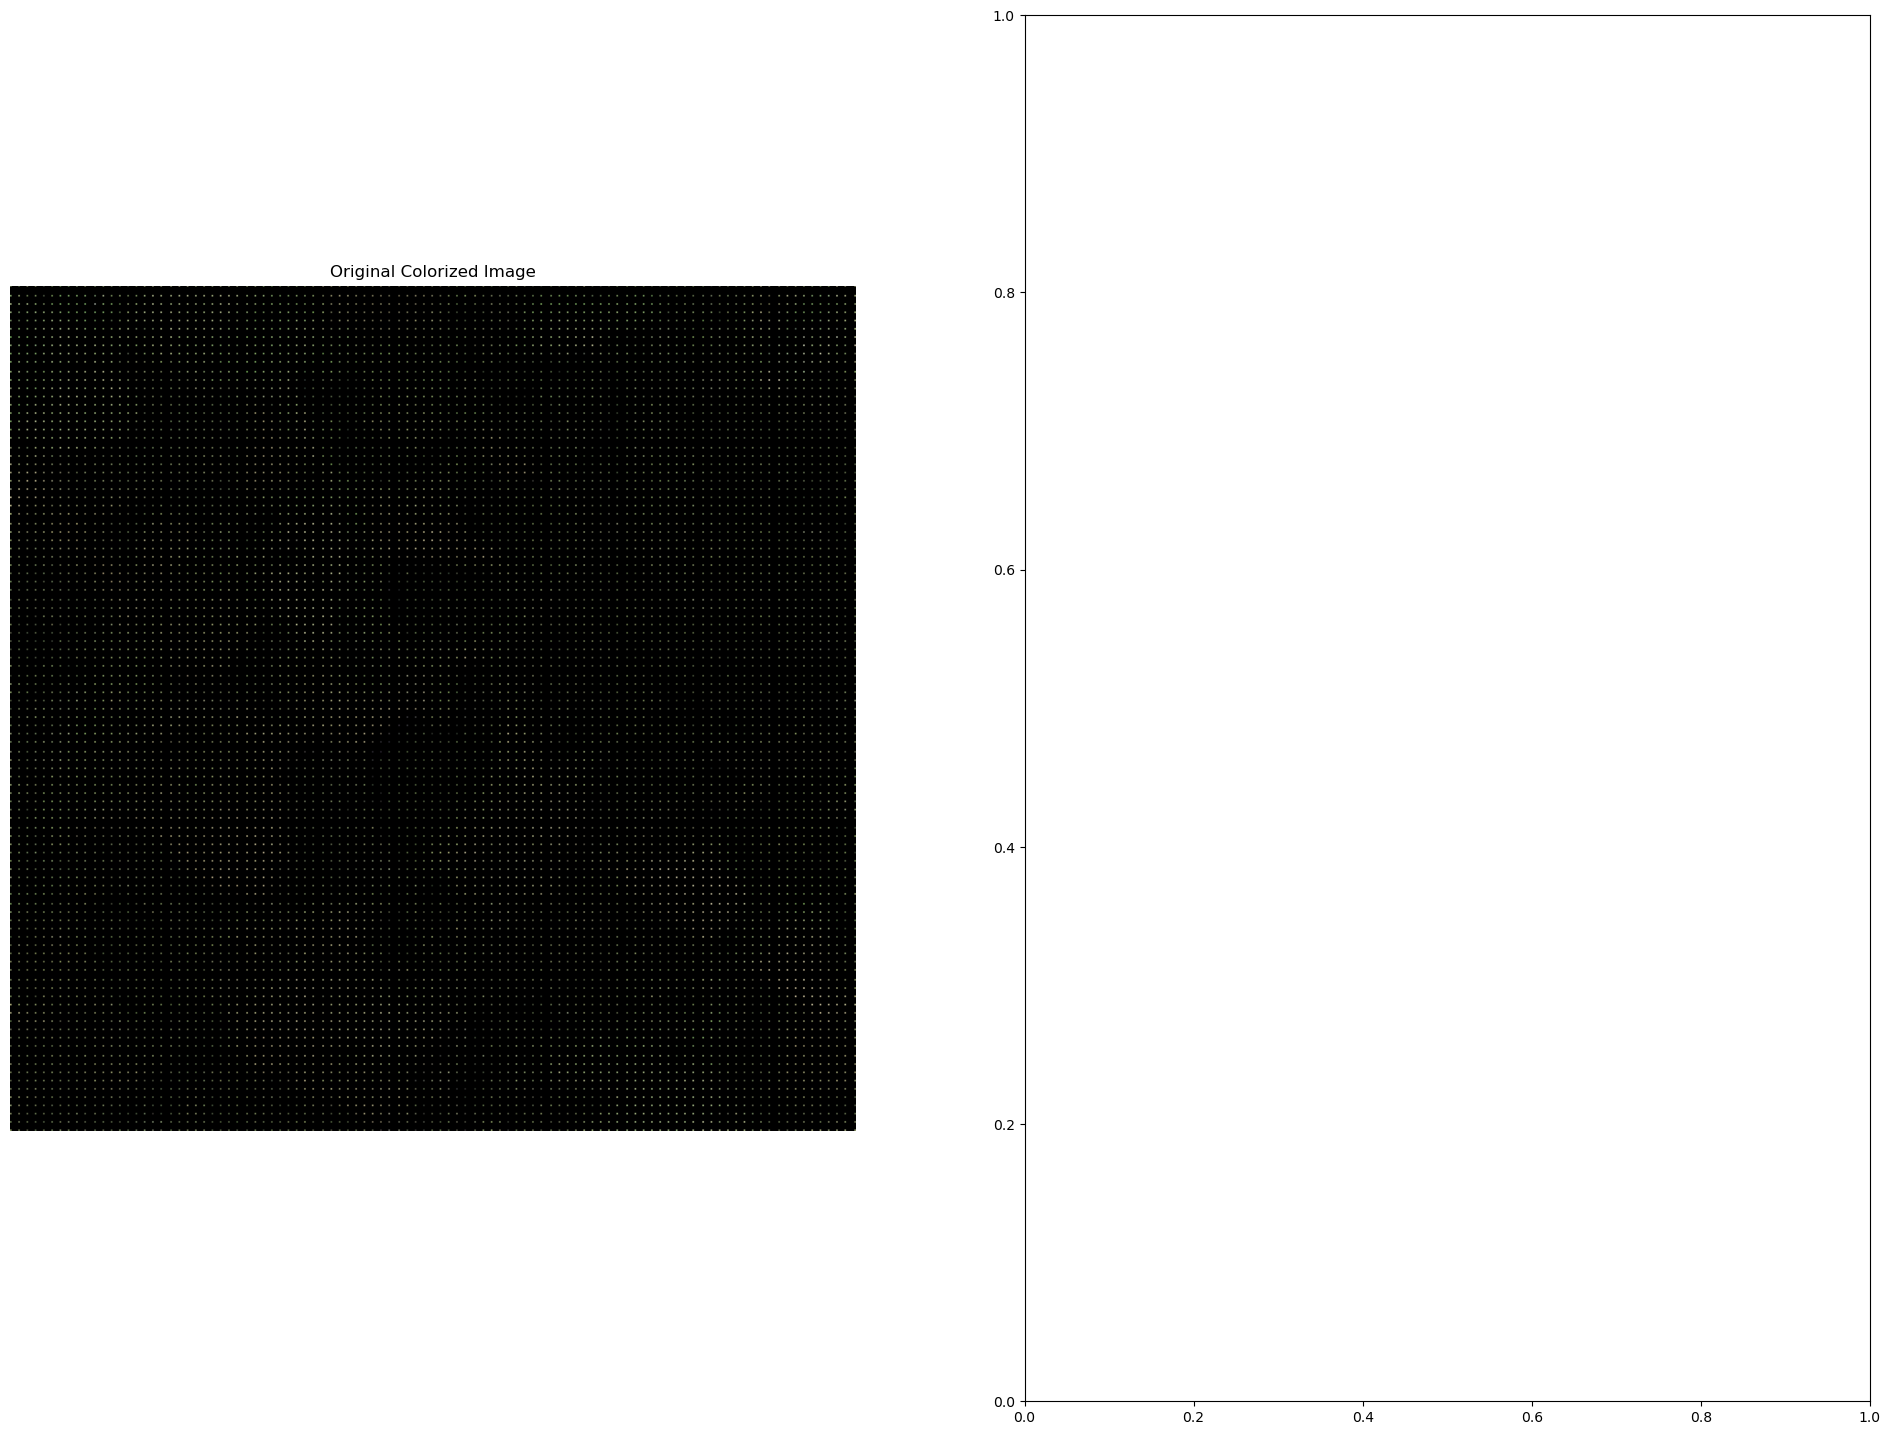

In [ ]:
# Extract X, Y, Z coordinates and color information (red, green, blue)
x = las.x
y = las.y
z = las.z
red = las.red
green = las.green
blue = las.blue

# Normalize X, Y to fit into a 2D grid (for the color image)
resolution = 512  # Output resolution for the images (nxn pixels)
x_min, x_max = np.min(las.header.x_min), np.max(las.header.x_max)
y_min, y_max = np.min(las.header.y_min), np.max(las.header.y_max)

# Normalize x and y to fit the 2D image grid
x_norm = ((x - x_min) / (x_max - x_min)) * (resolution - 1)
y_norm = ((y - y_min) / (y_max - y_min)) * (resolution - 1)

# Convert to integers for indexing
x_indices = np.clip(x_norm.astype(np.int32), 0, resolution - 1)
y_indices = np.clip(y_norm.astype(np.int32), 0, resolution - 1)

# Initialize color image
color_image = np.zeros((resolution, resolution, 3), dtype=np.uint8)

# Find maximum z value for each grid cell
flat_indices = y_indices * resolution + x_indices
unique_indices, inverse_indices = np.unique(flat_indices, return_inverse=True)

# Color image: Average RGB values for each cell
red_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)
green_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)
blue_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)

np.add.at(red_aggregated, inverse_indices, las.red / 65535 * 255)
np.add.at(green_aggregated, inverse_indices, las.green / 65535 * 255)
np.add.at(blue_aggregated, inverse_indices, las.blue / 65535 * 255)

# Assign aggregated colors to the color image
color_image.flat[unique_indices * 3] = (red_aggregated / np.bincount(inverse_indices)).astype(np.uint8)
color_image.flat[unique_indices * 3 + 1] = (green_aggregated / np.bincount(inverse_indices)).astype(np.uint8)
color_image.flat[unique_indices * 3 + 2] = (blue_aggregated / np.bincount(inverse_indices)).astype(np.uint8)

# Rasterize the polygon mask
polygon_mask = rasterize_polygon(hillfort_area, x_min, x_max, y_min, y_max, resolution)

# Overlay polygon mask onto colorized image
masked_color_image = np.copy(color_image)
masked_color_image[polygon_mask == 1] = [255, 0, 0];  # Highlight mask in red

# Apply transparency to the colorized image
masked_color_image = apply_transparency(color_image, polygon_mask, [255, 0, 0], 0.3)

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(24, 18))

# Original Colorized Image
axs[0].imshow(np.flip(color_image, axis=0))
axs[0].set_title('Original Colorized Image')
axs[0].axis('off')

# Masked Colorized Image
axs[1].imshow(np.flip(masked_color_image, axis=0))
axs[1].set_title('Masked Colorized Image with Polygon Overlay')
axs[1].axis('off')

plt.show()

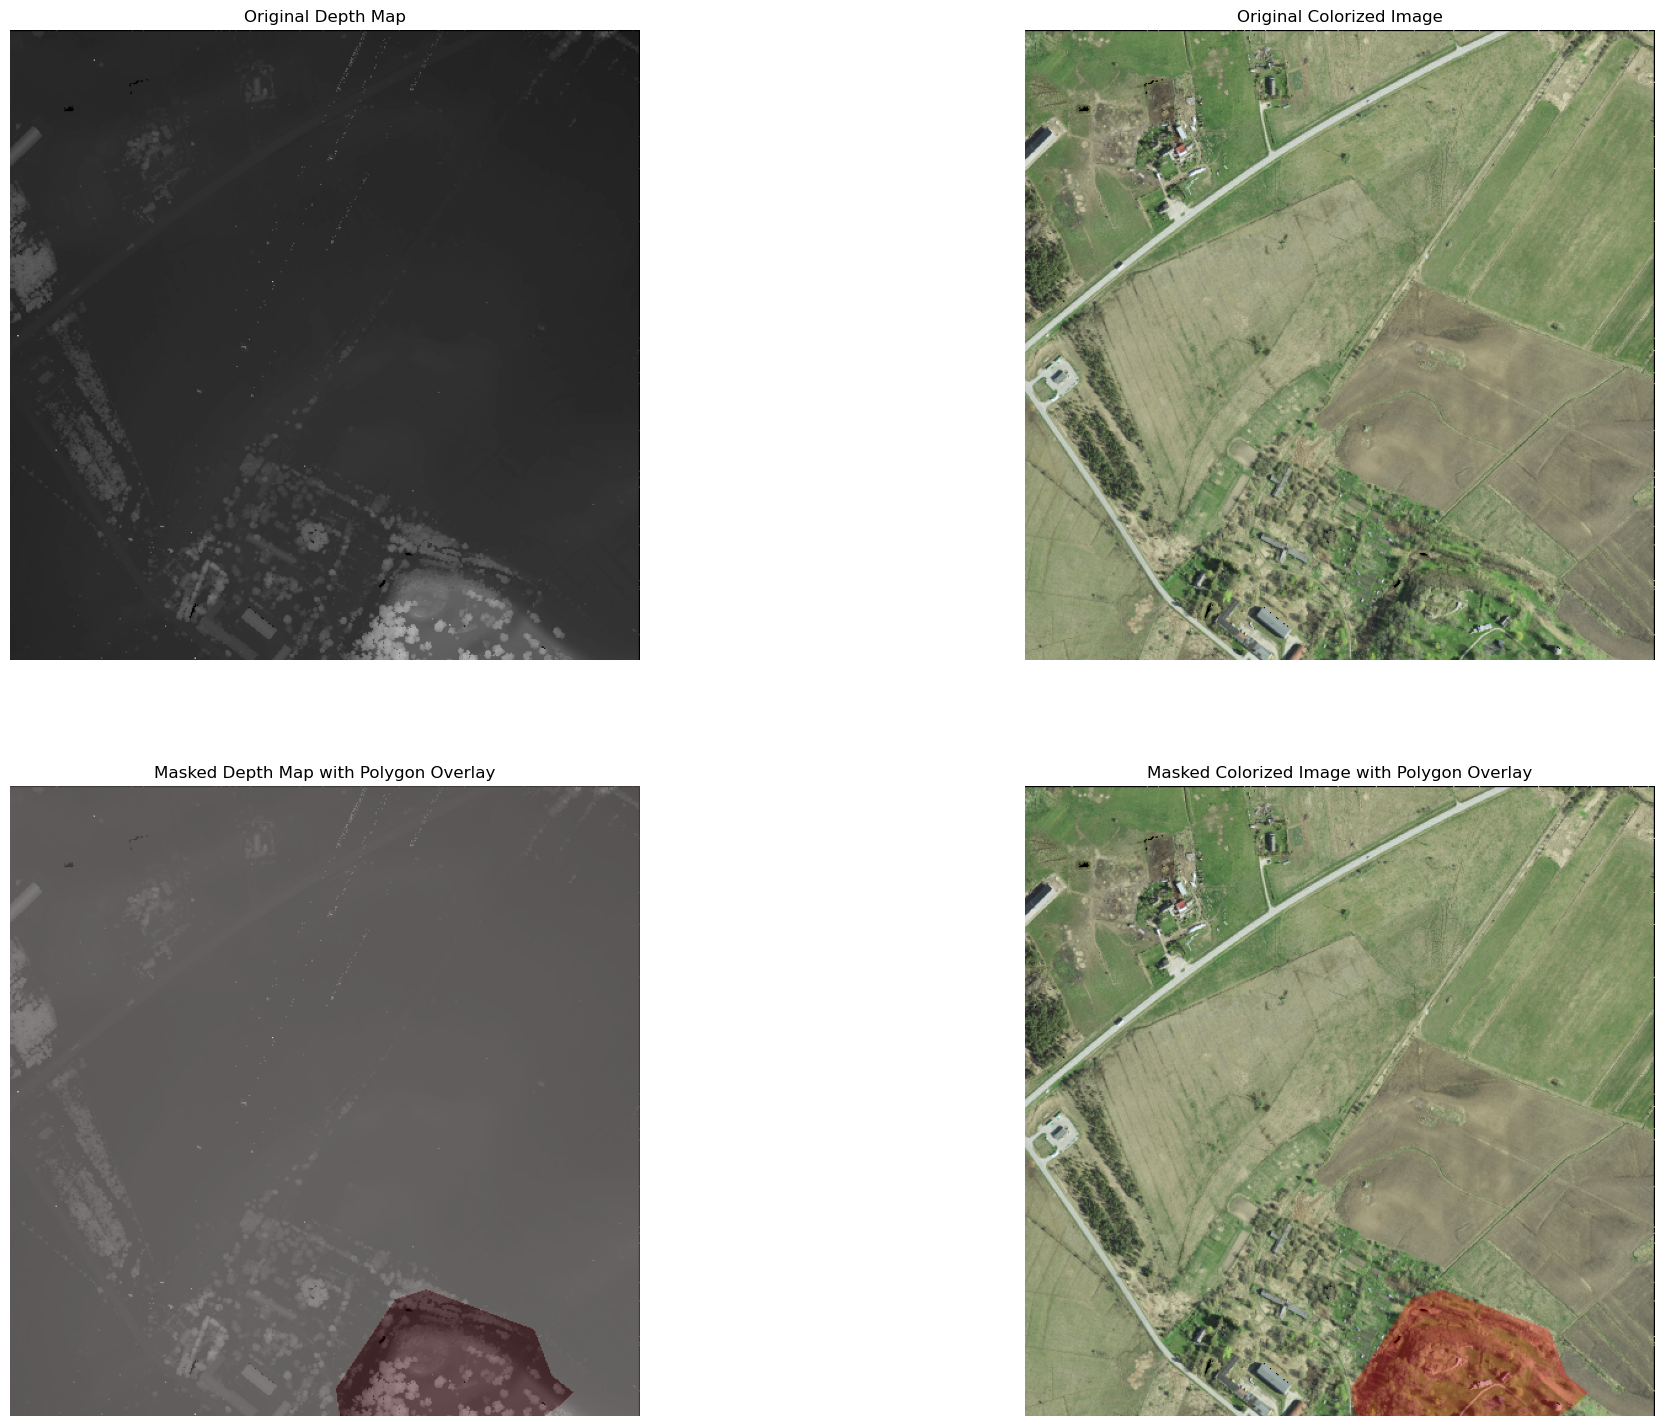

In [ ]:
# # Apply transparency to the colorized image
# masked_color_image = apply_transparency(np.flip(color_image, axis=0), np.flip(polygon_mask, axis=0), [255, 0, 0], 0.3)

# # Plot the results
# fig, axs = plt.subplots(2, 2, figsize=(24, 18))

# # Original Depth Map
# axs[0, 0].imshow(np.flip(depth_map_normalized, axis=0), cmap='gray')
# axs[0, 0].set_title('Original Depth Map')
# axs[0, 0].axis('off')

# # Original Colorized Image
# axs[0, 1].imshow(np.flip(color_image, axis=0))
# axs[0, 1].set_title('Original Colorized Image')
# axs[0, 1].axis('off')

# # Masked Depth Map
# axs[1, 0].imshow(np.flip(depth_map_normalized, axis=0), cmap='gray')
# axs[1, 0].imshow(np.flip(polygon_mask, axis=0), cmap='Reds', alpha=0.25)  # Overlay transparency
# axs[1, 0].set_title('Masked Depth Map with Polygon Overlay')
# axs[1, 0].axis('off')

# # Masked Colorized Image
# axs[1, 1].imshow(masked_color_image)
# axs[1, 1].set_title('Masked Colorized Image with Polygon Overlay')
# axs[1, 1].axis('off')

# plt.show()

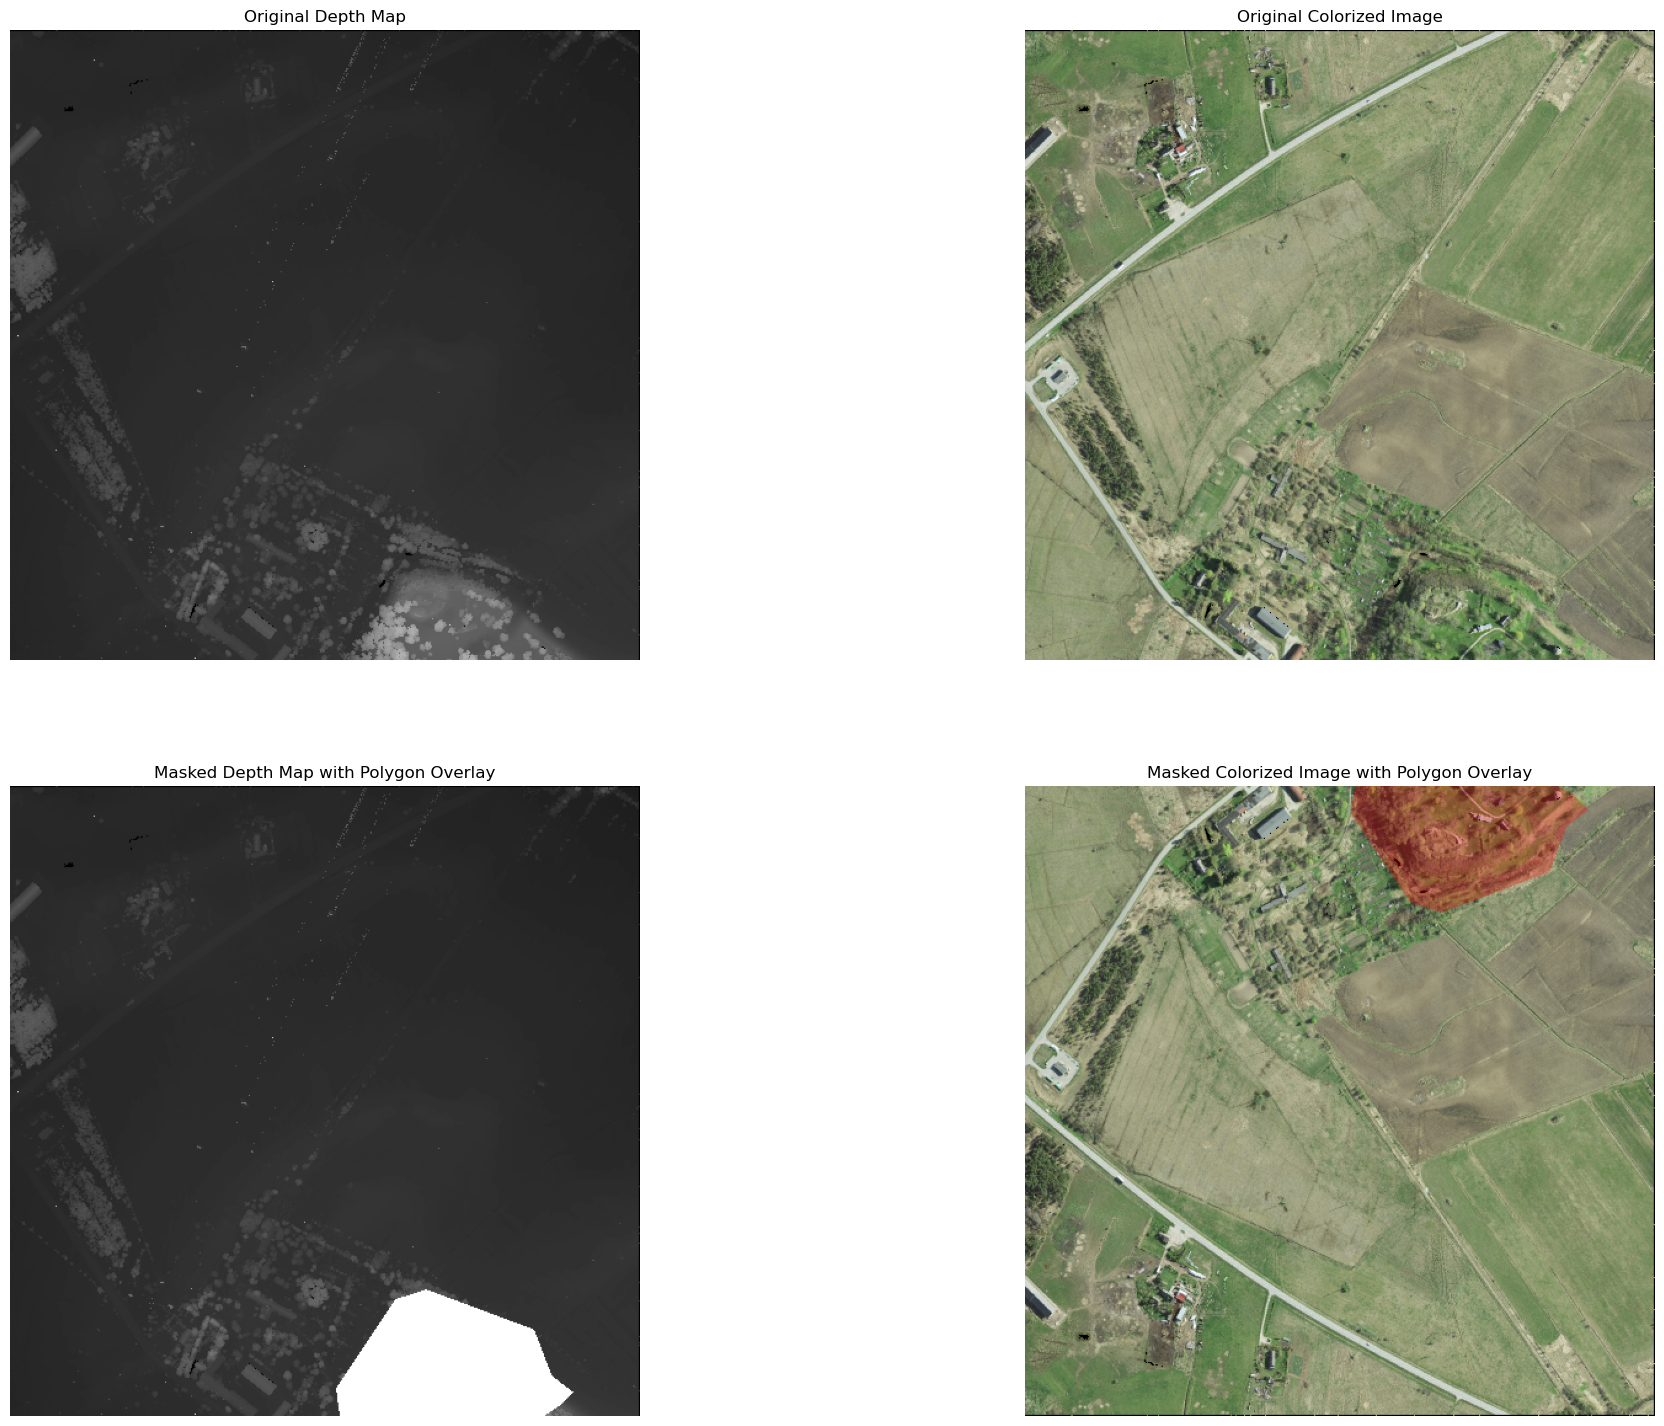

In [ ]:
# fig, axs = plt.subplots(2, 2, figsize=(24, 18))

# axs[0, 0].imshow(np.flip(depth_map_normalized, axis=0), cmap='gray')
# axs[0, 0].set_title('Original Depth Map')
# axs[0, 0].axis('off')

# # Original Colorized Image
# axs[0, 1].imshow(np.flip(color_image, axis=0))
# axs[0, 1].set_title('Original Colorized Image')
# axs[0, 1].axis('off')

# # Masked Depth Map
# axs[1, 0].imshow(np.flip(masked_depth_map, axis=0), cmap='gray')
# axs[1, 0].set_title('Masked Depth Map with Polygon Overlay')
# axs[1, 0].axis('off')

# # Masked Colorized Image
# axs[1, 1].imshow(np.flip(masked_color_image, axis=0))
# axs[1, 1].set_title('Masked Colorized Image with Polygon Overlay')
# axs[1, 1].axis('off')

# plt.show()

In [83]:
linnamaed = pd.read_csv('../data/linnamagede_ruudunumbrid.csv', sep=',')

In [84]:
linnamaed

Linnamägi                     Ruudunumber  \
0             Kivivarre Liinamägi                          439631   
1                   Agemäe linnus                          465667   
2            Ahisilla linnusekoht                          562567   
3                  Akupere linnus                             NaN   
4       Alatskivi Kalevipoja säng                          500680   
..                            ...                             ...   
132         Virussaare linnusease                  494520, 493520   
133               Vooru linnamägi                          444615   
134  Võuküla linnus Võhma maalinn                          489404   
135                  Helme linnus  432611, 432610, 431610, 431611   
136               Kirumpää linnus                          417677   

                                              Lisainfo    INSPIRE id  \
0                                                  NaN  mka_10077108   
1    pole kaardil märgitud, ruudu ülemises vasakus ...           NaN   
2          pole kaardil märgitud, Soone tn 6 kinnistul           NaN   
3                                  kaardil tuvastamatu  mka_10082860   
4                        ruudu ülemises paremas nurgas  mka_12458939   
..                                                 ...           ...   
132                                                NaN  mka_10080021   
133                                                NaN  mka_10077213   
134                                                NaN  mka_10079513   
135                                                NaN  mka_10080406   
136                                                NaN  mka_10083644   

                          INSPIRE nimi Unnamed: 5  
0    Linnus "Aakre Kivivare linnamägi"        NaN  
1                                  NaN        NaN  
2                                  NaN        NaN  
3              Linnus "Akupere linnus"        NaN  
4             Linnus "Kalevipoja säng"        NaN  
..                                 ...        ...  
132                          Pelgupaik        NaN  
133           Linnus "Vooru linnamägi"        NaN  
134                             Linnus        NaN  
135                   Helme mõisa park        NaN  
136                          Asulakoht        NaN  

[137 rows x 6 columns]

In [85]:
linnamaed[linnamaed['Ruudunumber'] == "506490"]

Linnamägi Ruudunumber Lisainfo    INSPIRE id       INSPIRE nimi  \
50  Lihula muinaslinnus      506490      NaN  mka_10079379  Lihula mõisa park   

   Unnamed: 5  
50        NaN

In [86]:
linnamaed.dropna(subset=['Ruudunumber', 'INSPIRE id'], how='any', inplace=True)

In [87]:
linnamaed

Linnamägi                     Ruudunumber  \
0             Kivivarre Liinamägi                          439631   
4       Alatskivi Kalevipoja säng                          500680   
5             Alatskivi linnamägi                          500681   
6             Alt-Laari Linnamägi                  463636, 462636   
7                         Alulinn                          590680   
..                            ...                             ...   
132         Virussaare linnusease                  494520, 493520   
133               Vooru linnamägi                          444615   
134  Võuküla linnus Võhma maalinn                          489404   
135                  Helme linnus  432611, 432610, 431610, 431611   
136               Kirumpää linnus                          417677   

                          Lisainfo    INSPIRE id  \
0                              NaN  mka_10077108   
4    ruudu ülemises paremas nurgas  mka_12458939   
5                              NaN  mka_10078885   
6                   südamekujuline  mka_12660497   
7                              NaN  mka_12693627   
..                             ...           ...   
132                            NaN  mka_10080021   
133                            NaN  mka_10077213   
134                            NaN  mka_10079513   
135                            NaN  mka_10080406   
136                            NaN  mka_10083644   

                          INSPIRE nimi Unnamed: 5  
0    Linnus "Aakre Kivivare linnamägi"        NaN  
4             Linnus "Kalevipoja säng"        NaN  
5                               Linnus        NaN  
6                   Linnus "Alt-Laari"        NaN  
7                     Linnus "Alulinn"        NaN  
..                                 ...        ...  
132                          Pelgupaik        NaN  
133           Linnus "Vooru linnamägi"        NaN  
134                             Linnus        NaN  
135                   Helme mõisa park        NaN  
136                          Asulakoht        NaN  

[111 rows x 6 columns]

In [88]:
# Load the Shapefile
gdf_inspire = gpd.read_file('../data/inspire/PS_ProtectedSite_malestisedPolygon.shp')
gdf_kpois = gpd.read_file('../data/kpois/kma_avalik_muinsuskaitse_241_1007-polygons.shp')

In [14]:
# Inspect the first few rows of the GeoDataFrame
display(gdf_inspire.head())
display
display(gdf_inspire[gdf_inspire['sitename_g'] == 'Linnus "Aakre Kivivare linnamägi"']['geometry'])

gml_id              gml_descri  \
0  mka_11997874  Last update:2024-08-26   
1  mka_11997875  Last update:2024-08-26   
2  mka_11997876  Last update:2024-08-26   
3  mka_11997877  Last update:2024-08-26   
4  mka_11997879  Last update:2024-08-26   

                                          gml_metada  \
0  https://metadata.geoportaal.ee/geonetwork/srv/...   
1  https://metadata.geoportaal.ee/geonetwork/srv/...   
2  https://metadata.geoportaal.ee/geonetwork/srv/...   
3  https://metadata.geoportaal.ee/geonetwork/srv/...   
4  https://metadata.geoportaal.ee/geonetwork/srv/...   

                          gml_metad0  \
0  Eesti kultuurimälestiste register   
1  Eesti kultuurimälestiste register   
2  Eesti kultuurimälestiste register   
3  Eesti kultuurimälestiste register   
4  Eesti kultuurimälestiste register   

                                   gml_origin     gml_parent    inspireid_  \
0  http://www.opengis.net/def/crs/EPSG/0/3301  featureMember  mka_11997874   
1  http://www.opengis.net/def/crs/EPSG/0/3301  featureMember  mka_11997875   
2  http://www.opengis.net/def/crs/EPSG/0/3301  featureMember  mka_11997876   
3  http://www.opengis.net/def/crs/EPSG/0/3301  featureMember  mka_11997877   
4  http://www.opengis.net/def/crs/EPSG/0/3301  featureMember  mka_11997879   

                            inspireid0  \
0  ee.mka.ps.registermuinas-malestised   
1  ee.mka.ps.registermuinas-malestised   
2  ee.mka.ps.registermuinas-malestised   
3  ee.mka.ps.registermuinas-malestised   
4  ee.mka.ps.registermuinas-malestised   

                                          sitedesign sitedesig0  \
0  https://inspire.ec.europa.eu/codelist/National...   monument   
1  https://inspire.ec.europa.eu/codelist/National...   monument   
2  https://inspire.ec.europa.eu/codelist/National...   monument   
3  https://inspire.ec.europa.eu/codelist/National...   monument   
4  https://inspire.ec.europa.eu/codelist/National...   monument   

                                          sitedesig1  \
0  https://inspire.ec.europa.eu/codelist/Designat...   
1  https://inspire.ec.europa.eu/codelist/Designat...   
2  https://inspire.ec.europa.eu/codelist/Designat...   
3  https://inspire.ec.europa.eu/codelist/Designat...   
4  https://inspire.ec.europa.eu/codelist/Designat...   

                  sitedesig2 sitename_g sitename_0      siteprotec  \
0  national monuments record     Kääbas        est  archaeological   
1  national monuments record     Kääbas        est  archaeological   
2  national monuments record     Kääbas        est  archaeological   
3  national monuments record     Kääbas        est  archaeological   
4  national monuments record     Kääbas        est  archaeological   

                                   xml_ns_uri legalfound legalfoun0  \
0  http://inspire.ec.europa.eu/schemas/ps/4.0       true       true   
1  http://inspire.ec.europa.eu/schemas/ps/4.0       true       true   
2  http://inspire.ec.europa.eu/schemas/ps/4.0       true       true   
3  http://inspire.ec.europa.eu/schemas/ps/4.0       true       true   
4  http://inspire.ec.europa.eu/schemas/ps/4.0       true       true   

                                            geometry  
0  POLYGON ((701009.29 6415775.3, 701010.57 64157...  
1  POLYGON ((701019.53 6415786.11, 701021.31 6415...  
2  POLYGON ((701015.43 6415752.13, 700998.44 6415...  
3  POLYGON ((700959.86 6415755.76, 700965.12 6415...  
4  POLYGON ((700981.56 6415774.09, 700983.26 6415...

586    POLYGON ((631888.22 6439387.11, 631895.55 6439...
Name: geometry, dtype: geometry

In [19]:
gdf_inspire[gdf_inspire['inspireid_'] == 'mka_10079379']

gml_id              gml_descri  \
1534  mka_10079379  Last update:2024-08-26   

                                             gml_metada  \
1534  https://metadata.geoportaal.ee/geonetwork/srv/...   

                             gml_metad0  \
1534  Eesti kultuurimälestiste register   

                                      gml_origin     gml_parent    inspireid_  \
1534  http://www.opengis.net/def/crs/EPSG/0/3301  featureMember  mka_10079379   

                               inspireid0  \
1534  ee.mka.ps.registermuinas-malestised   

                                             sitedesign sitedesig0  \
1534  https://inspire.ec.europa.eu/codelist/National...   monument   

                                             sitedesig1  \
1534  https://inspire.ec.europa.eu/codelist/Designat...   

                     sitedesig2         sitename_g sitename_0 siteprotec  \
1534  national monuments record  Lihula mõisa park        est   cultural   

                                      xml_ns_uri legalfound legalfoun0  \
1534  http://inspire.ec.europa.eu/schemas/ps/4.0       true       true   

                                               geometry  
1534  POLYGON ((490610.45 6505860.8, 490602.27 65058...

In [94]:
display(gdf_inspire.iloc[1534].geometry.bounds)
type(gdf_inspire.iloc[1534].geometry)

(490517.749999543, 6505860.799812593, 490894.9299995611, 6506200.289812606)

shapely.geometry.polygon.Polygon

In [ ]:
gdf_kpois['nimi'].info()
display(gdf_kpois['nimi'].isna().sum())

<class 'pandas.core.series.Series'>
RangeIndex: 5031 entries, 0 to 5030
Series name: nimi
Non-Null Count  Dtype 
--------------  ----- 
1992 non-null   object
dtypes: object(1)
memory usage: 39.4+ KB


3039

In [ ]:
gdf_inspire['sitename_g'].info()
display(gdf_inspire['sitename_g'].isna().sum())

<class 'pandas.core.series.Series'>
RangeIndex: 5092 entries, 0 to 5091
Series name: sitename_g
Non-Null Count  Dtype 
--------------  ----- 
5092 non-null   object
dtypes: object(1)
memory usage: 39.9+ KB


0

In [ ]:
'Lihula mõisa park' in gdf_kpois['nimi'].unique()

True

In [ ]:
'Linnus "Aakre Kivivare linnamägi"' in gdf_kpois['nimi'].unique()

False

In [ ]:
'Linnus "Aakre Kivivare linnamägi"' in gdf_inspire['sitename_g'].unique()

True

In [ ]:
'Lihula mõisa park' in gdf_inspire['sitename_g'].unique()

True

In [21]:
np.unique(las.points.classification, return_counts=True) # unique, counts

(array([ 1,  2,  5,  6,  7,  9, 18], dtype=uint8),
 array([ 528729, 2248151,  188398,   25863,      43,   13229,       3],
       dtype=int64))

In [24]:
polygon = gdf_inspire.iloc[1534].geometry

points = np.column_stack((las.x, las.y))

In [147]:
np.unique(las.points.classification, return_counts=True) # unique, counts

(array([ 1,  2,  5,  6,  7,  9, 12, 18], dtype=uint8),
 array([ 511699, 2143864,  138861,   24396,      33,     679,  184881,
              3], dtype=int64))

In [25]:
# Convert points to a Shapely GeometryArray (vectorized)
points_geom = shapely.points(points)

# Pre-filter points using the polygon's bounding box
bbox_mask = shapely.contains(shapely.box(*polygon.bounds), points_geom)

# Apply fine-grained point-in-polygon test to remaining points
final_mask = shapely.contains(polygon, points_geom[bbox_mask])

# Combine masks
mask = np.zeros(len(points), dtype=bool)
mask[bbox_mask] = final_mask

# Apply the new classification to points within the polygon
las.classification[mask] = 12

In [26]:
np.unique(las.points.classification, return_counts=True) # unique, counts

(array([ 1,  2,  5,  6,  7,  9, 12, 18], dtype=uint8),
 array([ 511699, 2143864,  138861,   24396,      33,     679,  184881,
              3], dtype=int64))

In [ ]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

Metadata:
Width: 5000, Height: 5000
CRS: EPSG:3301
Bounds: BoundingBox(left=490000.0, bottom=6505000.0, right=495000.0, top=6510000.0)
Number of Bands: 1
Transform: | 1.00, 0.00, 490000.00|
| 0.00,-1.00, 6510000.00|
| 0.00, 0.00, 1.00|


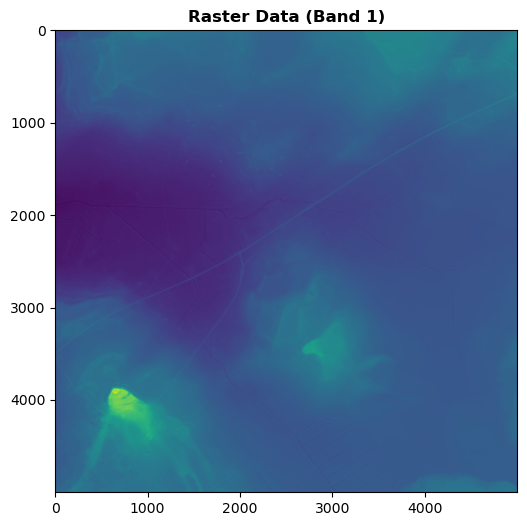

In [ ]:
with rasterio.open('../62093_dtm_1m.tif') as rio:
    # Display basic metadata
    print("Metadata:")
    print(f"Width: {rio.width}, Height: {rio.height}")
    print(f"CRS: {rio.crs}")
    print(f"Bounds: {rio.bounds}")
    print(f"Number of Bands: {rio.count}")
    print(f"Transform: {rio.transform}")
    
    # Read the first band (if applicable)
    band1 = rio.read(1)  # Assuming single-band raster or you can specify another band index
    
    # Plot the raster
    plt.figure(figsize=(10, 6))
    show(band1, title="Raster Data (Band 1)")
    plt.show()